# Analyzing the data
So far I'm just playing some randomized samples from each class in the training set, as well as the test sequences, just in order to make it easier to see what we're working with.

## Unzip dataset
In order for this to work, you'll have to access the file called 'building_106_kitchen.zip' (.wav dataset). How you do that is up to you. I uploaded it to my drive and access it from there.

In [1]:
# run once, also runtime may ask to be restarted, that's fine
!pip install rockpool
!pip install --upgrade "jax[cpu]"
!pip install jax==0.4.20 jaxlib==0.4.20
!pip install samna
!pip install bitstruct

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 550.7/550.7 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rockpool: filename=rockpool-3.0.3-py3-none-any.whl size=675907 sha256=c6f83af492613da89523181e3d46d49b7d42c47c2480ef4f2d330fc4bb7cc02e
  Stored in directory: /root/.cache/pip/wheels/e3/7c/bf/49b9bd3b69f317c2ed76c1c6d05102995500b7433416de6665
Successfully built rockpool
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 121.0 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.2
    Uninstalling jaxlib-0.7.2:
      Successfully uninstalled jaxlib-0.7.2
  Attempting uninstall: jax
    Found existing installation: jax 0.7.2
    Uninstalling jax-0.7.2:
      Successfully uninstalled jax-0.7.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 6.5 M

In [2]:
from zipfile import ZipFile
import os
from IPython.display import Image, Audio, display
import numpy as np
import scipy as sp
import librosa
import random
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm import tqdm
import gc

from rockpool.devices.xylo.syns61201 import AFESim
from rockpool.timeseries import TimeSeries, TSContinuous

import torch
import torch.optim as optim
import torch.nn.functional as F

from torch.optim import Adam, lr_scheduler
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, random_split
from rockpool.nn.modules import LIFTorch, LinearTorch, ExpSynTorch, LIFExodus
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from rockpool.utilities.backend_management import backend_available

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import seaborn as sns



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

AttributeError: _ARRAY_API not found

In [3]:
# run this if you upload to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extract wav files
zip_file_path = '/content/drive/MyDrive/D7046E_SNN_project_dataset/building_106_kitchen.zip'
extract_path = '/content/dataset'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# run this if you upload to colab directly
#zip_file_path = '/content/building_106_kitchen.zip'
#extract_path = '/content/dataset'

#with ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_path)

## Play sample from each training class


In [ ]:
# path to each training class
train_segments_path = '/content/dataset/building_106_kitchen/training_segments'
class_directories = []
for item in os.listdir(train_segments_path):
    item_path = os.path.join(train_segments_path, item)
    if os.path.isdir(item_path):
        class_directories.append(item)

# one random audio sample from each class
# run this cell again to get different samples
for class_name in class_directories:
    class_path = os.path.join(train_segments_path, class_name)
    wav_files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
    if wav_files:
        random_wav_file = random.choice(wav_files)
        print(f"\nClass: {class_name}")
        display(Audio(os.path.join(class_path, random_wav_file)))


## Play each test sequence

In [ ]:
test_sequence_path = '/content/dataset/building_106_kitchen/test_sequence'
for filename in os.listdir(test_sequence_path):
    if filename.endswith('.wav'):
        file_path = os.path.join(test_sequence_path, filename)
        print(f"\nSequence: {filename}")
        display(Audio(file_path))

# Converting audio data into spike data
I'm likely gonna base this on [this tutorial](https://rockpool.ai/devices/analog-frontend-example.html) from Rockwell documentation on how to convert audio data into spike, though our data is in .wav format so some small extra steps are needed. It seems rockwell wants the audio as a numpy array.

Basically, in the Rockpool library there is AFEsim, a simulation of the analog front-end module of the Xylo Audio 2 device, a piece of neuromorphic hardware, which converts audio frequency bands into spikes. We can use this to convert a .wav file into spike data.

## Convert and plot one sample

In [ ]:
# parameters for AFESim
fs = 110e3                          # The sampling frequency of the input, in Hz
raster_period = 10e-3               # The output rasterisation time-step in seconds
max_spike_per_raster_period = 15    # Maximum number of events per output time-step

# set them false for now
add_noise = False                   # Enables / disables simulated noise generated by the AFE
add_offset = False                  # Add mismatch offset to each filter
add_mismatch = False                # Add simualted mismatch to filter parameters
seed = None                         # Seed for mistmatch generation

In [ ]:
# should input AFESim and path to .wav file and ouput spike representation
def wav_to_spikes(path, afe):
    audio, sr = librosa.load(path, sr=None, mono=True)
    print(audio)

    # create a time vector for time series object
    times = np.arange(len(audio)) / sr

    # rockpool continuous time series
    ts_audio = TSContinuous(times, audio[:, None])

    # pass through AFESim
    spikes, state, rec = afe(ts_audio)

    return spikes, state, rec


In [ ]:
# initialize the AFE simulation
afe = AFESim(
        fs = fs,
        raster_period = raster_period,
        max_spike_per_raster_period = max_spike_per_raster_period,
        add_noise = add_noise,
        add_offset = add_offset,
        add_mismatch = add_mismatch,
        seed = seed,
).timed()

# load one random audio sample
random_class_name = random.choice(class_directories)
random_class_path = os.path.join(train_segments_path, random_class_name)
wav_files_in_random_class = [f for f in os.listdir(random_class_path) if f.endswith('.wav')]
random_audio_file = random.choice(wav_files_in_random_class)

audio_path = os.path.join(random_class_path, random_audio_file)
print(f"Class: {random_class_name}, File: {random_audio_file}")

audio, sr = librosa.load(audio_path, sr=None, mono=True)

# convert to spikes
spike_output, _, _= wav_to_spikes(audio_path, afe)
print("Spike format:")
print(type(spike_output))

spike_times = spike_output.times
spike_channels = spike_output.channels

# listen
display(Audio(audio_path))

# waveform plot
fig, ax = plt.subplots(3, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[1,1,1]})

t_audio = np.arange(len(audio)) / sr
ax[0].plot(t_audio, audio, linewidth=0.8)
ax[0].set_title("Audio waveform")
ax[0].set_ylabel("Amplitude")

# spike raster
ax[1].scatter(spike_times, spike_channels, s=5, marker='.', alpha=0.7)
ax[1].set_title("Spike raster from AFESim")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Channel")
ax[1].set_ylim(-1, 16)     # AFESim uses 16 filterbank channels

raster_matrix = spike_output.raster(dt=10e-3, add_events=True)  # 10 ms bins
ax[2].imshow(raster_matrix.T, aspect="auto", origin="lower")
ax[2].set_xlabel("Time bin")
ax[2].set_ylabel("Channel")
ax[2].set_title("Spike heatmap")

plt.tight_layout()
plt.show()

## Note on plot
We can see here that the AFE simulation has 16 outputs, and this is because of a band-pass filter bank which splits the (audio) signal into 16 bands. The lowest band, index 0, has a centre frequency of 40 and the highest band, index 15, has a centre frequency of 16940, as shown in the code cell just below. I believe we should be able to tune the bands if we wanted to. [AFESim documentation](https://rockpool.ai/reference/_autosummary/devices.xylo.syns61201.AFESim.html) shows a bunch of parameters we might be interested in looking at or even tuning.

In [ ]:
print("Center frequencies:", afe.module.fcs)

# Custom dataset loader
Because we have our own dataset, unlike the tutorial we can't use Tonic to create datloaders, but create a custom dataset class. We also need to convert every single .wav file to a tensor, which is very computationally heavy.

In [4]:
class SpikeRasterDataset(Dataset):
    def __init__(self, sample_info_path, transform=None):
        self.sample_info = np.load(sample_info_path, allow_pickle=True)
        self.transform = transform

    def __len__(self):
        return len(self.sample_info)

    def __getitem__(self, idx):
        spike_path, class_label = self.sample_info[idx]

        class_idx = torch.tensor(int(class_label), dtype=torch.long)

        spikes = np.load(spike_path)
        if self.transform is not None:
            spikes = self.transform(spikes)

        spikes = torch.from_numpy(spikes).float()
        return spikes, class_idx


In [5]:
# copies dataset from drive to local files
# makes loading faster since we're not loading from drive
!cp -r /content/drive/MyDrive/D7046E_SNN_project_dataset /content/data


In [15]:
# loads directly from drive:
# dataset_path = '/content/drive/MyDrive/D7046E_SNN_project_dataset/kitchen_spike_dataset/sample_info.npy'

# if you ran the cell above this will be faster:
dataset_path = '/content/data/kitchen_spike_dataset/sample_info.npy'

dataset = SpikeRasterDataset(dataset_path)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print("train set size:\t",train_size)
print("val set size:\t",val_size)
print("test set size:\t",test_size)
print("total size:\t",total_size)

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

train set size:	 1031
val set size:	 220
test set size:	 222
total size:	 1473


Spike shape: (300, 16)
Label: 4


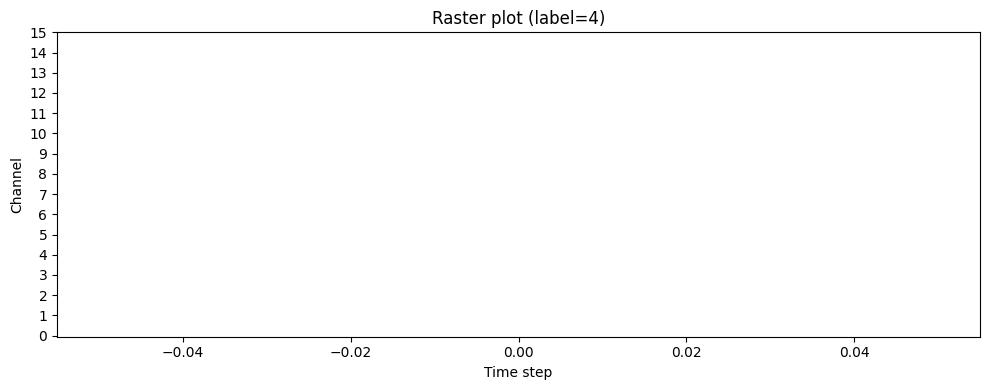

From metadata:
class_to_idx
 background: 0
 bag: 1
 blender: 2
 cornflakes_bowl: 3
 cornflakes_eating: 4
 cup: 5
 dish_washer: 6
 electric_razor: 7
 flatware_sorting: 8
 food_processor: 9
 hair_dryer: 10
 microwave: 11
 microwave_bell: 12
 microwave_door: 13
 plates_sorting: 14
 stirring_cup: 15
 toaster_up_down: 16
 toilet_button: 17
 toilet_flush: 18
 tooth: 19
 vacuum_cleaner: 20
 washing_machine: 21
 water_boiler: 22
 water_tap: 23



In [16]:
# visualize any sample just to make sure it looks ok
import numpy as np
import matplotlib.pyplot as plt

sample_info = np.load(dataset_path, allow_pickle=True)

spike_path, label = sample_info[250]
spikes = np.load(spike_path)

print("Spike shape:", spikes.shape)
print("Label:", label)

def plot_spike_raster(spikes, title=None):
    T, C = spikes.shape

    times = []
    channels = []

    for t in range(T):
        for c in range(C):
            count = int(spikes[t, c])
            if count > 0:
                times.extend([t] * count)
                channels.extend([c] * count)

    plt.figure(figsize=(10, 4))
    plt.scatter(times, channels, s=2)
    plt.xlabel("Time step")
    plt.ylabel("Channel")
    plt.yticks(range(C))
    plt.title(title or "Spike Raster Plot")
    plt.tight_layout()
    plt.show()

plot_spike_raster(spikes, title=f"Raster plot (label={label})")

print("From metadata:\nclass_to_idx\n","background: 0\n","bag: 1\n",
    "blender: 2\n","cornflakes_bowl: 3\n","cornflakes_eating: 4\n",
    "cup: 5\n","dish_washer: 6\n","electric_razor: 7\n",
    "flatware_sorting: 8\n","food_processor: 9\n","hair_dryer: 10\n",
    "microwave: 11\n","microwave_bell: 12\n","microwave_door: 13\n",
    "plates_sorting: 14\n","stirring_cup: 15\n","toaster_up_down: 16\n",
    "toilet_button: 17\n","toilet_flush: 18\n","tooth: 19\n",
    "vacuum_cleaner: 20\n","washing_machine: 21\n","water_boiler: 22\n",
    "water_tap: 23\n"
  )

Note: some of theses files seem to contain no spikes at all. We should consider filtering them out.

# Training algorithm
This is more or less lifted exactly from the [tutorial](https://rockpool.ai/tutorials/rockpool-shd.html). We can change/tune this later after testing.

In [8]:
net_channels = 16
# i'll try making these parameters not constant to see how they train
tau_mem=Constant(200e-3)
#tau_mem = torch.nn.Parameter(torch.tensor(200e-3))
tau_syn=Constant(200e-3)
#tau_syn = torch.nn.Parameter(torch.tensor(200e-3))
#threshold=Constant(1.)
threshold = torch.nn.Parameter(torch.tensor(1.))
#bias = Constant(0.)
bias = torch.nn.Parameter(torch.tensor(0.))
net_dt = 10e-3
has_rec = False


# - Select a neuron model to use
from rockpool.utilities.backend_management import backend_available
NeuronModel = LIFExodus if backend_available('sinabs-exodus') and torch.cuda.is_available() else LIFTorch

# - Network Definition
def SimpleNet(Nin, Nhidden, Nout):
    return Sequential(
        LinearTorch((Nin, Nhidden), has_bias=False),
        NeuronModel(Nhidden,
            tau_mem=tau_mem,
            tau_syn=tau_syn,
            threshold=threshold,
            bias=bias,
            dt=net_dt,
            has_rec=has_rec),
        LinearTorch((Nhidden, Nout), has_bias = False),
        ExpSynTorch(Nout, dt=net_dt, tau=Constant(5e-3))
    )

NOTE: Adjusting tau_mem and tau_syn, or making them trainable parameters has a high chance of making the SNN unstable (loss = NaN). Making threshold and bias trainable seems to be beneficial however.

In [9]:
# - Build a network
Nin = net_channels
Nhidden = 20
Nout = 24

torch.manual_seed(1234) # A manual seed ensures repeatability

net = SimpleNet(Nin, Nhidden, Nout)
print(net)

TorchSequential  with shape (16, 24) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    LinearTorch '2_LinearTorch' with shape (20, 24)
    ExpSynTorch '3_ExpSynTorch' with shape (24,)
}


Sample shape: torch.Size([300, 16])
Output shape: torch.Size([1, 300, 24])
Output min/max: -30.929258346557617 31.192378997802734


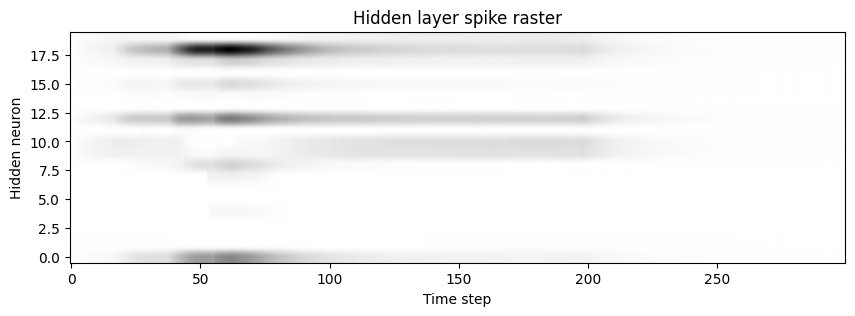

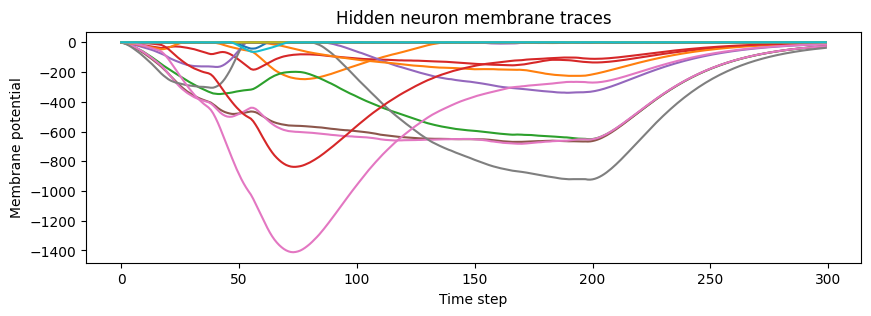

In [10]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(dev)

events, labels = next(iter(train_loader)) # Get a batch from the train dataloader
events = events.to_dense().to(dev)
sample = events[0,:,:] # Get the first sample from the first batch

output, state, rec = net(sample, record=True) # Pass the first sample through the network

print("Sample shape:", sample.shape)      # expected: [T, Nin]
print("Output shape:", output.shape)      # expected: [T, Nout]
print("Output min/max:", output.min().item(), output.max().item())

#print(rec.keys())

# visualize hidden layer
hidden_spikes = rec["1_LIFTorch"]["spikes"][0]

plt.figure(figsize=(10, 3))
plt.imshow(hidden_spikes.T.cpu().detach().numpy(), aspect="auto", origin="lower", cmap="Greys")
plt.xlabel("Time step")
plt.ylabel("Hidden neuron")
plt.title("Hidden layer spike raster")
plt.show()

vmem = rec["1_LIFTorch"]["vmem"][0]

plt.figure(figsize=(10, 3))
plt.plot(vmem.cpu().detach().numpy())
plt.xlabel("Time step")
plt.ylabel("Membrane potential")
plt.title("Hidden neuron membrane traces")
plt.show()

In [11]:
# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-3, weight_decay=1e-5)

# schedulers reduce learning rate during training
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)

# - Loss function
loss_fun = CrossEntropyLoss()

# - Record the loss values over training iterations
accuracy = []
loss_t = []
num_epochs = 500

best_val_loss = float("inf")
checkpoint_path = "/content/drive/MyDrive/D7046E_SNN_project_dataset/best_model_noisy_test.pth"

train_acc = []
train_loss = []
val_acc = []
val_loss = []

hasnt_improved_count = 0

# - Training Loop
with tqdm(range(num_epochs), unit="Epoch", desc="Training") as pbar:
    for epoch in pbar:
        # Training
        net.train()
        correct = 0
        total = 0
        running_loss = 0.0

        for events, labels in train_loader:
            events, labels = events.to(dev), labels.to(dev)

            output, _, _ = net(events)
            logits = output.mean(dim=1)

            loss = loss_fun(logits, labels)

            optimizer.zero_grad()

            loss.backward()

            # gradient clipping, so we don't explode when training tau (hopefully)
            #torch.nn.utils.clip_grad_norm_(net.parameters().astorch(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item() * labels.size(0)

            preds = torch.argmax(logits, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        #scheduler.step()

        epoch_train_loss = running_loss / total
        epoch_train_acc = 100 * correct / total

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        # Validation
        net.eval()
        correct = 0
        total = 0
        running_loss = 0.0

        with torch.no_grad():
            for events, labels in val_loader:
                events, labels = events.to(dev), labels.to(dev)

                output, _, _ = net(events)

                # instead of just summing spikes, this should
                # take temporal nature into consideration(?)
                logits = output.mean(dim=1)

                loss = loss_fun(logits, labels)
                running_loss += loss.item() * labels.size(0)

                preds = torch.argmax(logits, dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        epoch_val_loss = running_loss / total
        epoch_val_acc = 100 * correct / total

        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": net.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": best_val_loss,
                },
                checkpoint_path
            )
            hasnt_improved_count = 0
        else:
            hasnt_improved_count += 1

        if hasnt_improved_count >= 20:
            print("\nStopping early")
            break

        pbar.set_postfix(
            TrainLoss=f"{epoch_train_loss:.3f}",
            ValLoss=f"{epoch_val_loss:.3f}",
            TrainAcc=f"{epoch_train_acc:.1f}%",
            ValAcc=f"{epoch_val_acc:.1f}%"
        )


Training:  27%|██▋       | 135/500 [31:08<1:24:11, 13.84s/Epoch, TrainAcc=73.0%, TrainLoss=1.025, ValAcc=68.2%, ValLoss=1.504]

Stopping early


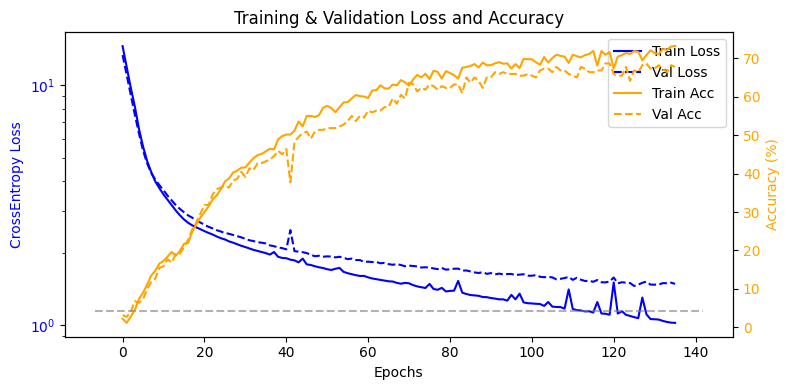

In [12]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# Loss
ax1.plot(train_loss, label="Train Loss", color="blue")
ax1.plot(val_loss, label="Val Loss", color="blue", linestyle="--")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("CrossEntropy Loss", color="blue")
ax1.set_yscale("log")
ax1.tick_params(axis="y", labelcolor="blue")

# Accuracy
ax2 = ax1.twinx()
ax2.plot(train_acc, label="Train Acc", color="orange")
ax2.plot(val_acc, label="Val Acc", color="orange", linestyle="--")
ax2.set_ylabel("Accuracy (%)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Chance-level baseline (1 / num_classes)
chance_level = 100 / 24
ax2.plot(ax2.get_xlim(), [chance_level, chance_level], "--", color="gray", alpha=0.6)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Training & Validation Loss and Accuracy")
plt.tight_layout()
plt.show()


NOTE: The training stopped early because validation loss stopped decreasing

Loaded best model from epoch 144 (val loss = 1.3065)
Test Accuracy : 79.09%
Precision     : 0.743
Recall        : 0.760
F1-score      : 0.726

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.88      0.44         8
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           5       0.50      1.00      0.67         2
           6       0.94      0.94      0.94        18
           7       1.00      0.89      0.94        18
           8       1.00      0.60      0.75         5
           9       0.29      0.67      0.40         3
          10       1.00      1.00      1.00        14
          11       0.81      0.93      0.87        14
          12       1.00      0.71      0.83         7
          13       0.90      0.69      0.78        13
          14       0.81

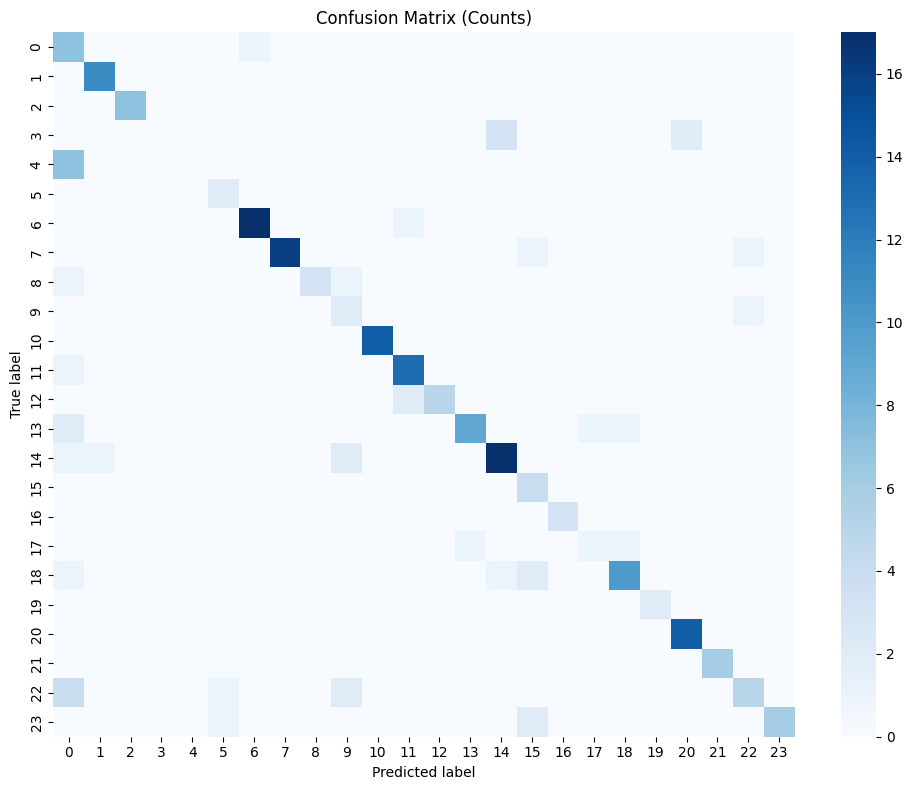

In [19]:
# - Test loop with sklearn metrics
checkpoint_path = "/content/drive/MyDrive/D7046E_SNN_project_dataset/best_model2.pth"
checkpoint = torch.load(checkpoint_path, map_location=dev)
net.load_state_dict(checkpoint["model_state_dict"])
net.to(dev)

print(
    f"Loaded best model from epoch {checkpoint['epoch']} "
    f"(val loss = {checkpoint['val_loss']:.4f})"
)

net.eval()

all_preds = []
all_labels = []



with torch.no_grad():
    for events, labels in val_loader:
        events, labels = events.to(dev), labels.to(dev)

        output, _, _ = net(events)
        logits = output.mean(dim=1)

        loss = loss_fun(logits, labels)
        running_loss += loss.item() * labels.size(0)

        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Accuracy
acc = accuracy_score(all_labels, all_preds) * 100

# Precision / Recall / F1 (macro = treats all classes equally)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average="macro",
    zero_division=0
)

print(f"Test Accuracy : {acc:.2f}%")
print(f"Precision     : {precision:.3f}")
print(f"Recall        : {recall:.3f}")
print(f"F1-score      : {f1:.3f}")

# Full per-class report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, zero_division=0))

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=range(24),
    yticklabels=range(24)
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

Note: It seems to be very bad at predicting class 4, cornflakes eating. Worth looking into why. Maybe it's so quiet it doesn't generate spikes?